In [1]:
#Notebook Setup
import sys
sys.path.append('/Volumes/albright_postdoc/2022_AADAWM_v3/bin/')
import utils as ut # <----- your commmonly used functions go here!
import plots as pt
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline

In [2]:
df = pd.read_csv('20230831_log_ap_df.csv').rename(columns={'Unnamed: 0': 'gene'}).set_index('gene')

# during quality control we decided to remove samples tub1 and con2
wanted = [c for c in df.columns if ('tub1' not in c) & ('con2' not in c)]
df = df[wanted]
df = df[(df > 0.5).sum(axis=1) > 5]
df.head()

,con1A,con1P,con4A,con4P,con5A,con5P,tub2A,tub2P,tub3A,tub3P,tub4A,tub4P,tub5A,tub5P
gene,,,,,,,,,,,,,,
SteCoe_1,5.349854,4.989153,5.127702,4.887665,5.228895,4.786168,4.989477,4.736124,4.523944,4.451671,4.342233,4.346424,4.427971,4.245021
SteCoe_10,3.350268,3.336839,3.428746,3.414961,3.108005,3.184861,3.254499,3.457830,3.247583,3.247879,3.428435,3.615790,3.580345,3.577666
SteCoe_100,0.993052,0.782278,0.859221,0.694524,0.665635,0.686154,0.777479,1.019169,0.943652,0.726260,0.975460,0.717819,0.900047,0.827687
SteCoe_1000,3.239880,3.089762,3.118806,3.309043,3.226041,3.162337,3.908425,3.889541,3.866846,4.010330,4.160089,3.875912,3.600053,3.750749
SteCoe_10002,3.244158,3.470455,3.533868,3.217456,3.389556,3.346047,3.109947,3.395441,3.299408,3.218290,3.465352,3.451553,3.563797,3.700718


## Quality Control - PCA

Calculating the PC space here on control only

In [3]:
colors = ['#008080']

<AxesSubplot:xlabel='PC1, 34.49%', ylabel='PC2, 22.03%'>

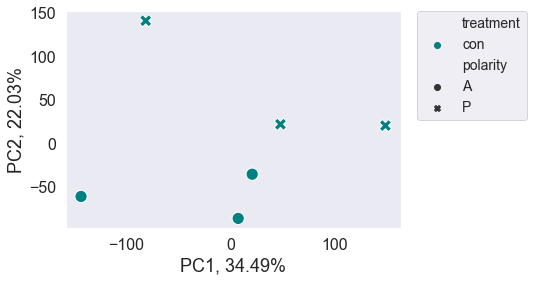

In [4]:
# compute pca:
control_cols = df.columns[df.columns.str.contains('con')]
scaler, pca = ut.get_pc(df[control_cols], n_pcs=2, which='pca')
pc = ut.get_pc(df[control_cols], n_pcs=2, which='pc') 
explained_variance = pca.explained_variance_ratio_  # convert to percentage

pt.plot_pc(pc, explained_variance, colors = colors)
# #plt.xticks([-50, 0, 50, 100])
# #plt.yticks([-50, 0, 50, 100])
#plt.savefig('PCA_tub_control.png', bbox_inches='tight', dpi = 300)

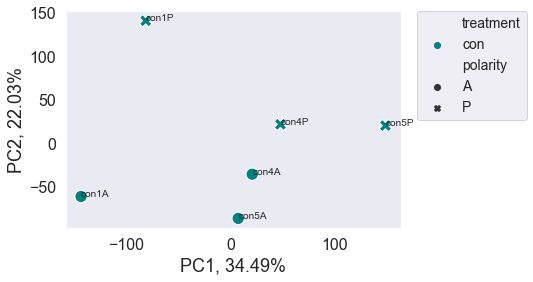

In [5]:
# same plot, samples labeled 
pt.plot_pc(pc, explained_variance, colors = colors)
for sample in pc.index:
    s = pc.reindex([sample])
    plt.annotate(sample, (s.PC1, s.PC2))


#plt.savefig('PCA_control.png', bbox_inches='tight', dpi = 300)

Note: PC2 resembles the anterior-posterior axis overall trending more A on the bottom and more P at the top

Transform the rest of the dataset: 

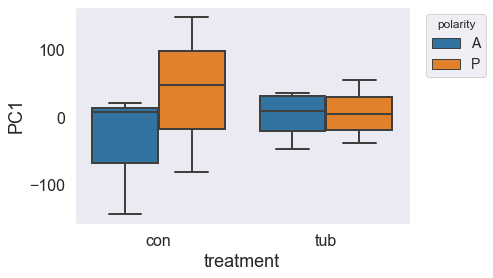

In [6]:
coords2 = pca.transform(scaler.transform(df.T))  # Transform the entire dataset using control PC space from above

# get coordinates into a nice dataframe
pc = pd.DataFrame(coords2, index=df.columns, columns=['PC1', 'PC2'])

# annotate metadata:
pc['treatment'] = pd.Series(pc.index).astype(str).str[:3].values
pc['polarity'] = pd.Series(pc.index).astype(str).str[-1].values
sns.boxplot(x='treatment', y='PC1', hue='polarity', data=pc)
legend = plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1))
legend.set_title("polarity")

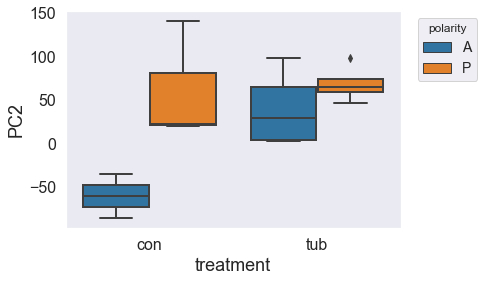

In [7]:
sns.boxplot(x='treatment', y='PC2', hue='polarity', data=pc)
legend = plt.legend(loc='upper right', bbox_to_anchor=(1.25 , 1))
legend.set_title("polarity")

#plt.savefig('PC2_tub.png', bbox_inches='tight', dpi = 300)

In [8]:
colors = ['#008080', '#E62BA9']

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

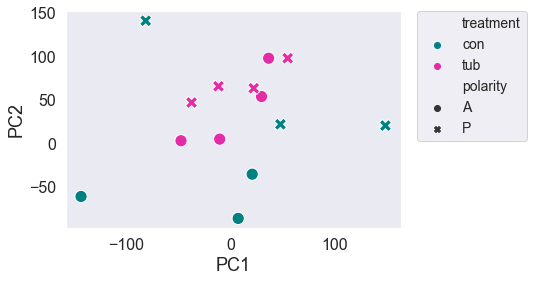

In [9]:
# PCA all samples
pt.plot_pc(pc, colors = colors)
#plt.savefig('PCA_tub.png', bbox_inches='tight', dpi = 300)

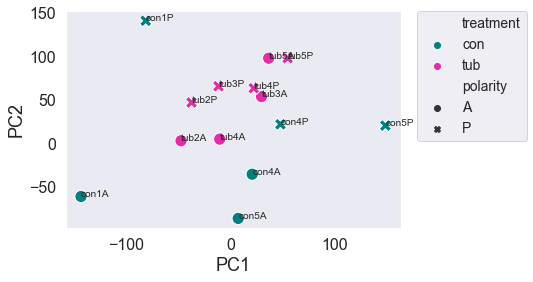

In [10]:
# PCA, all samples labeled 
pt.plot_pc(pc, colors = colors)
for sample in pc.index:
    s = pc.reindex([sample])
    plt.annotate(sample, (s.PC1, s.PC2))

## Data wrangling and math 

In [11]:
stack = ut.tidy_up(df)
stack.head()

,,Sample,log1TPM,treatment,Polarity,sample_mean_log1TPM,log1RPM,log1RPM_posterior,sample_mean_log1TPM_posterior,Skew
gene,Cell_ID,,,,,,,,,
SteCoe_1,con1,con1A,5.349854,con,A,2.025427,7.375281,7.018505,2.029352,0.024787
SteCoe_10,con1,con1A,3.350268,con,A,2.025427,5.375695,5.366191,2.029352,0.000885
SteCoe_100,con1,con1A,0.993052,con,A,2.025427,3.018479,2.811630,2.029352,0.035479
SteCoe_1000,con1,con1A,3.239880,con,A,2.025427,5.265307,5.119114,2.029352,0.014078
SteCoe_10002,con1,con1A,3.244158,con,A,2.025427,5.269585,5.499806,2.029352,-0.021377


/Users/aralbright/opt/anaconda3/envs/scoe-rna/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/aralbright/opt/anaconda3/envs/scoe-rna/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


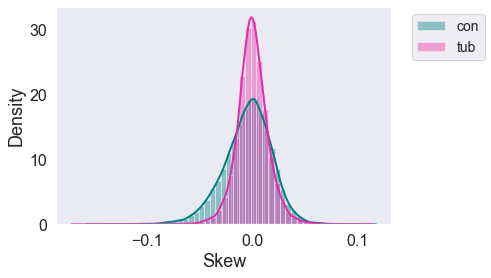

In [12]:
# visualize a histogram of mean skews.
mean_skews = ut.get_mean_skew(stack)

sns.distplot(mean_skews[mean_skews.treatment == 'con'].Skew, color = colors[0], label = 'con')
sns.distplot(mean_skews[mean_skews.treatment == 'tub'].Skew, color = colors[1], label = 'tub')
legend = plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))

#plt.savefig('skew_dist_tub.png', bbox_inches='tight', dpi = 300)

(0.0, 0.1)

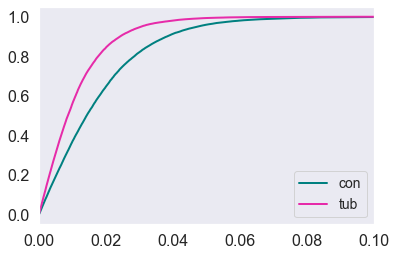

In [13]:
abs_cond = lambda x: np.abs(mean_skews[mean_skews.treatment == x].Skew)
plt.plot(*ut.ecdf(abs_cond('con')), color = colors[0], label = 'con')
plt.plot(*ut.ecdf(abs_cond('tub')), color = colors[1], label = 'tub')
plt.legend()
plt.xlim(0, .1)

25097


/Users/aralbright/opt/anaconda3/envs/scoe-rna/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/aralbright/opt/anaconda3/envs/scoe-rna/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

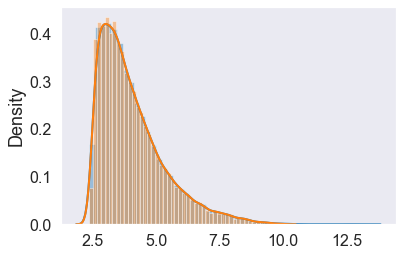

In [14]:
# make sure RPMs are within a reasonable range:
mean_rpm = stack.groupby('gene')[['log1RPM_posterior', 'log1RPM']].mean().mean(axis=1)
wanted = mean_rpm[mean_rpm.between(2, 10)].index
print(len(wanted))
sns.distplot(mean_rpm)
sns.distplot(mean_rpm[mean_rpm.between(2, 10)])

In [15]:
# compute coefficient of variation(std / mean) so we don't test things that are
# so variable that they would never be stat sig differentially expressed
# therefore reducing our FDR penalty

stack = stack.reset_index()[stack.reset_index().gene.isin(wanted)]
stack['coeff'] = stack.groupby(['gene', 'treatment']).Skew\
                            .transform(lambda x: np.std(x) / np.abs(np.mean(x)))
stack.sort_values(['gene', 'Cell_ID'], inplace=True)
stack.head()

,gene,Cell_ID,Sample,log1TPM,treatment,Polarity,sample_mean_log1TPM,log1RPM,log1RPM_posterior,sample_mean_log1TPM_posterior,Skew,coeff
0,SteCoe_1,con1,con1A,5.349854,con,A,2.025427,7.375281,7.018505,2.029352,0.024787,0.213256
25115,SteCoe_1,con4,con4A,5.127702,con,A,2.016021,7.143723,6.906566,2.018901,0.016879,0.213256
50230,SteCoe_1,con5,con5A,5.228895,con,A,2.016201,7.245096,6.836772,2.050603,0.028996,0.213256
75345,SteCoe_1,tub2,tub2A,4.989477,tub,A,2.037216,7.026694,6.773815,2.037691,0.018324,0.771406
100460,SteCoe_1,tub3,tub3A,4.523944,tub,A,2.042141,6.566085,6.484710,2.033039,0.006235,0.771406


/Users/aralbright/opt/anaconda3/envs/scoe-rna/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'log(Coefficent of Variation)')

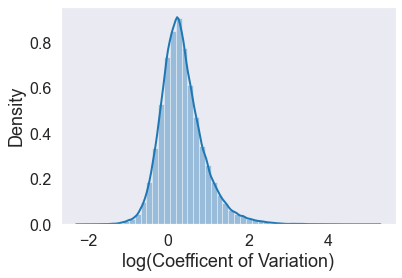

In [16]:
sns.distplot(stack.coeff.apply(np.log10))
plt.xlabel('log(Coefficent of Variation)')

In [17]:
# remove genes where the coefficient of variation is >2 
stacky = stack[stack.coeff < 2]

In [18]:
stacky

,gene,Cell_ID,Sample,log1TPM,treatment,Polarity,sample_mean_log1TPM,log1RPM,log1RPM_posterior,sample_mean_log1TPM_posterior,Skew,coeff
0,SteCoe_1,con1,con1A,5.349854,con,A,2.025427,7.375281,7.018505,2.029352,0.024787,0.213256
25115,SteCoe_1,con4,con4A,5.127702,con,A,2.016021,7.143723,6.906566,2.018901,0.016879,0.213256
50230,SteCoe_1,con5,con5A,5.228895,con,A,2.016201,7.245096,6.836772,2.050603,0.028996,0.213256
75345,SteCoe_1,tub2,tub2A,4.989477,tub,A,2.037216,7.026694,6.773815,2.037691,0.018324,0.771406
100460,SteCoe_1,tub3,tub3A,4.523944,tub,A,2.042141,6.566085,6.484710,2.033039,0.006235,0.771406
...,...,...,...,...,...,...,...,...,...,...,...,...
150688,SteCoe_9998,tub4,tub4A,2.918468,tub,A,2.030285,4.948752,5.032691,2.034805,-0.008409,1.209109
175803,SteCoe_9998,tub5,tub5A,3.449470,tub,A,2.041397,5.490867,5.608858,2.050657,-0.010630,1.209109
25114,SteCoe_9999,con1,con1A,1.980763,con,A,2.025427,4.006190,4.058510,2.029352,-0.006488,1.554400
50229,SteCoe_9999,con4,con4A,1.396240,con,A,2.016021,3.412261,3.899241,2.018901,-0.066605,1.554400


## Significance Testing

In [19]:
df_tub = ut.sig_test(stacky, condition = 'tub', qval_threshold = 0.15, pc_index = 1)
df_tub[df_tub.sig]

Number of genes:  7049


,gene,Cell_ID,Sample,log1TPM,treatment,Polarity,sample_mean_log1TPM,log1RPM,log1RPM_posterior,sample_mean_log1TPM_posterior,Skew,coeff,p_value,q_value,sig
356,SteCoe_10500,con1,con1A,1.999143,con,A,2.025427,4.024570,3.885522,2.029352,0.017579,0.586365,0.0426116,0.146927,True
25471,SteCoe_10500,con4,con4A,1.840044,con,A,2.016021,3.856065,3.762321,2.018901,0.012305,0.586365,0.0426116,0.146927,True
50586,SteCoe_10500,con5,con5A,1.974177,con,A,2.016201,3.990378,3.638510,2.050603,0.046123,0.586365,0.0426116,0.146927,True
75701,SteCoe_10500,tub2,tub2A,1.507542,tub,A,2.037216,3.544758,3.716311,2.037691,-0.023626,0.317173,0.0426116,0.146927,True
100816,SteCoe_10500,tub3,tub3A,1.573473,tub,A,2.042141,3.615613,3.790796,2.033039,-0.023653,0.317173,0.0426116,0.146927,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74864,SteCoe_937,con5,con5A,2.789131,con,A,2.016201,4.805332,5.015300,2.050603,-0.021380,0.911632,0.0221189,0.13817,True
99979,SteCoe_937,tub2,tub2A,2.368804,tub,A,2.037216,4.406020,4.050770,2.037691,0.042008,0.498673,0.0221189,0.13817,True
125094,SteCoe_937,tub3,tub3A,2.500963,tub,A,2.042141,4.543103,4.216552,2.033039,0.037279,0.498673,0.0221189,0.13817,True
150209,SteCoe_937,tub4,tub4A,2.489262,tub,A,2.030285,4.519547,4.452378,2.034805,0.007487,0.498673,0.0221189,0.13817,True


In [20]:
# Keep only rows where the 'gene' column value is unique
# Keep only the first occurrence of each unique 'gene' value
df_tub = df_tub.drop_duplicates(subset='gene', keep='first')

/Users/aralbright/opt/anaconda3/envs/scoe-rna/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='q_value', ylabel='Density'>

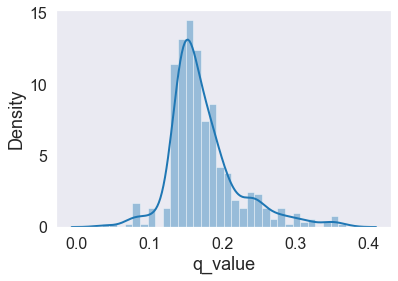

In [21]:
sns.distplot(df_tub['q_value'])

In [22]:
df_tub[df_tub.sig].sort_values('q_value')

,gene,Cell_ID,Sample,log1TPM,treatment,Polarity,sample_mean_log1TPM,log1RPM,log1RPM_posterior,sample_mean_log1TPM_posterior,Skew,coeff,p_value,q_value,sig
23252,SteCoe_7537,con1,con1A,2.522611,con,A,2.025427,4.548038,4.988447,2.029352,-0.046182,0.065200,6.93601e-05,0.03468,True
9203,SteCoe_22383,con1,con1A,1.180097,con,A,2.025427,3.205524,3.496744,2.029352,-0.043451,0.157764,0.000189624,0.0474061,True
19325,SteCoe_36530,con1,con1A,0.762811,con,A,2.025427,2.788237,3.142857,2.029352,-0.059790,0.167170,0.000422298,0.0703831,True
15954,SteCoe_31640,con1,con1A,2.787110,con,A,2.025427,4.812537,5.618887,2.029352,-0.077300,0.120095,0.00139836,0.0801728,True
8433,SteCoe_21357,con1,con1A,1.461823,con,A,2.025427,3.487250,3.332153,2.029352,0.022743,0.040101,0.0017638,0.0801728,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16874,SteCoe_32925,con1,con1A,2.246588,con,A,2.025427,4.272015,5.340367,2.029352,-0.111143,0.318318,0.0455514,0.146927,True
17004,SteCoe_33099,con1,con1A,2.341629,con,A,2.025427,4.367055,3.877884,2.029352,0.059330,0.467603,0.0382204,0.146927,True
18705,SteCoe_3562,con1,con1A,1.380871,con,A,2.025427,3.406297,3.663105,2.029352,-0.036327,0.964333,0.0417117,0.146927,True
19828,SteCoe_37363,con1,con1A,2.902347,con,A,2.025427,4.927773,5.017259,2.029352,-0.008998,0.991217,0.0387896,0.146927,True


Add protein domain to table: 

In [23]:
# load protein domain information 

x = []
y = []
with open('/Users/aralbright/Documents/GitHub/2022_skew_analysis/S_coeruleus_Nov2017_proteins.fasta') as f:
    lines = f.readlines()
    for l in lines:
        if '>' in l:
            line = l.split('\t')
            gene = line[0][1:]
            domain = line[1].strip()
            x += [gene]
            y += [domain]

prot_data = pd.DataFrame([x, y], index=['gene', 'domain']).T.set_index('gene')

In [24]:
df_tub = df_tub.join(prot_data, on = 'gene')

In [25]:
df_tub

,gene,Cell_ID,Sample,log1TPM,treatment,Polarity,sample_mean_log1TPM,log1RPM,log1RPM_posterior,sample_mean_log1TPM_posterior,Skew,coeff,p_value,q_value,sig,domain
36,SteCoe_10047,con1,con1A,0.725730,con,A,2.025427,2.751157,3.071599,2.029352,-0.055033,0.768164,0.0848843,0.162849,False,Akt family kinase
202,SteCoe_10277,con1,con1A,5.589870,con,A,2.025427,7.615297,7.556768,2.029352,0.003858,0.725710,0.0814365,0.162849,False,Aha1_N domain protein
249,SteCoe_10346,con1,con1A,2.405543,con,A,2.025427,4.430969,4.347181,2.029352,0.009545,0.600413,0.0703424,0.158283,False,hypothetical protein
356,SteCoe_10500,con1,con1A,1.999143,con,A,2.025427,4.024570,3.885522,2.029352,0.017579,0.586365,0.0426116,0.146927,True,Dymeclin domain protein
363,SteCoe_10508,con1,con1A,1.040854,con,A,2.025427,3.066281,2.566910,2.029352,0.088648,0.272675,0.00873595,0.136373,True,hypothetical protein
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24890,SteCoe_970,con1,con1A,2.261419,con,A,2.025427,4.286846,4.818897,2.029352,-0.058430,0.470119,0.151076,0.194244,False,hypothetical protein
24899,SteCoe_9713,con1,con1A,1.112406,con,A,2.025427,3.137833,4.226331,2.029352,-0.147810,0.378181,0.272126,0.283465,False,hypothetical protein
24918,SteCoe_9735,con1,con1A,4.894690,con,A,2.025427,6.920117,6.759887,2.029352,0.011713,0.751846,0.0885056,0.162849,False,Palm_thioest domain protein
25003,SteCoe_9848,con1,con1A,4.294195,con,A,2.025427,6.319622,6.795323,2.029352,-0.036272,0.483018,0.181975,0.214088,False,hypothetical protein


In [27]:
#df_tub.to_csv('df_tub_allskew.csv', index=False)

In [28]:
df_tub_sig = df_tub[df_tub.sig]

In [29]:
#df_tub_sig.to_csv('df_tub_sig.csv', index=False)

## Heatmap

In [30]:
hm_df = stack.pivot(index='gene', columns='Cell_ID', values='Skew')

In [31]:
tub_cm_order = pd.read_csv('/Volumes/albright_postdoc/2022_AADAWM_v3/1_bulk_ap/tub_cm_order.csv')

In [32]:
hm_df_filtered = hm_df[hm_df.index.isin(tub_cm_order['gene'])]
hm_df_ordered = hm_df_filtered.reindex(tub_cm_order['gene'])

In [33]:
len(hm_df_ordered)

51

labeling specific genes in sns.clustermap: https://github.com/mwaskom/seaborn/issues/2070

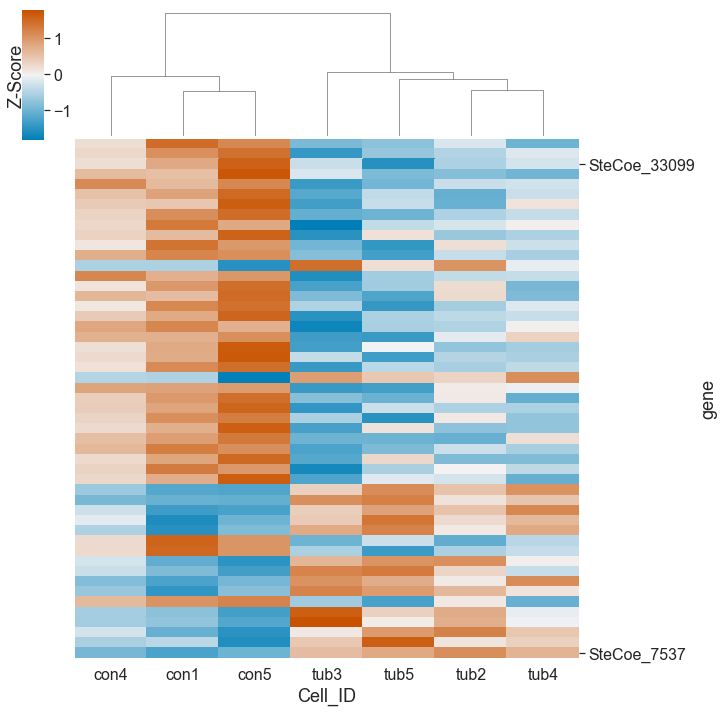

In [34]:
# clustermap
palette = sns.diverging_palette(240, 24, s=100, l=50, as_cmap=True)

p = sns.clustermap(
    hm_df_ordered,
    z_score=0,
    cmap=palette,
    row_cluster=False,
    col_cluster=True,
    dendrogram_ratio=(0.1, 0.2)
)

# get reordered labels from the dendrogram
reordered_labels = hm_df_ordered.index.tolist() 

# genes to label 
use_labels = ['SteCoe_33099', 'SteCoe_7537']
use_ticks = [reordered_labels.index(label) + 0.5 for label in use_labels]

# set labels 
p.ax_heatmap.set(yticks=use_ticks, yticklabels=use_labels)

# color bar position and such 
cbar = p.ax_cbar
cbar_pos = cbar.get_position()
cbar.set_ylabel('Z-Score')
cbar.yaxis.set_label_coords(-0.7, 0.5)
cbar.set_position([cbar_pos.x0, cbar_pos.y0, 0.03, cbar_pos.height])


#plt.savefig('ap_tub_skew_cm.png', bbox_to_inches='tight', dpi=300)

## Single gene plots

<AxesSubplot:title={'center':'SteCoe_7537'}, xlabel='treatment', ylabel='Skew'>

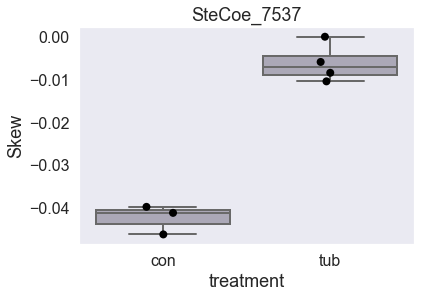

In [35]:
# PP2C

hit = "SteCoe_7537"
sns.boxplot(data = stack[stack.gene == hit], x = 'treatment', y = 'Skew', color = ('#A9A5BA')).set(title = hit)
sns.stripplot(data = stack[stack.gene == hit], x = 'treatment', y = 'Skew', color = "black", size = 8)
#plt.ylim(-0.12, 0.05)

#plt.savefig('tub_SteCoe_7537.png', bbox_inches = 'tight', dpi = 300)

<AxesSubplot:title={'center':'SteCoe_33099'}, xlabel='treatment', ylabel='Skew'>

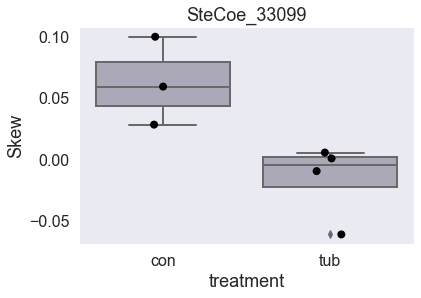

In [36]:
# one of the anterior genes with greatest LFC in bulk data 

hit = "SteCoe_33099"
sns.boxplot(data = stack[stack.gene == hit], x = 'treatment', y = 'Skew', color = ('#A9A5BA')).set(title = hit)
sns.stripplot(data = stack[stack.gene == hit], x = 'treatment', y = 'Skew', color = "black", size = 8)
#plt.ylim(-0.12, 0.05)

#plt.savefig('tub_SteCoe_33099.png', bbox_inches='tight', dpi = 300)
